<a href="https://colab.research.google.com/github/gpasxos/large-scale-optimization/blob/main/ch05_chambolle_pock_ctr_least_squares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chambolle-Pock Algorithm for Constrained Least Squares

## Problem Formulation

We solve the **equality-constrained least squares** problem:

$$\min_{x \in \mathbb{R}^n} \frac{1}{2}\|Ax - b\|_2^2 \quad \text{subject to} \quad Cx = d$$

where:
- $A \in \mathbb{R}^{m \times n}$: measurement matrix
- $b \in \mathbb{R}^m$: observations
- $C \in \mathbb{R}^{p \times n}$: constraint matrix
- $d \in \mathbb{R}^p$: constraint right-hand side

---

## Saddle-Point Reformulation

We reformulate using Lagrangian duality. The constraint $Cx = d$ is equivalent to:

$$\max_{y} \left\{ \langle Cx, y \rangle - \delta_{\{d\}}^*(y) \right\} = \max_{y} \left\{ \langle Cx, y \rangle - \langle d, y \rangle \right\}$$

where $\delta_{\{d\}}^*(y) = \langle d, y \rangle$ is the convex conjugate of the indicator function.

This gives the **primal-dual saddle-point problem**:

$$\min_{x} \max_{y} \left\{ \underbrace{\frac{1}{2}\|Ax - b\|_2^2}_{g(x)} + \langle Cx, y \rangle - \underbrace{\langle d, y \rangle}_{h^*(y)} \right\}$$

---

## The Chambolle-Pock Algorithm (PDHG)

The **Primal-Dual Hybrid Gradient** method solves the general saddle-point problem:

$$\min_{x} \max_{y} \left\{ g(x) + \langle Kx, y \rangle - h^*(y) \right\}$$

### Algorithm Updates

$$\boxed{
\begin{aligned}
y^{k+1} &= \mathbf{prox}_{\sigma h^*}\left( y^k + \sigma K \bar{x}^k \right) \\[0.5em]
x^{k+1} &= \mathbf{prox}_{\tau g}\left( x^k - \tau K^\top y^{k+1} \right) \\[0.5em]
\bar{x}^{k+1} &= x^{k+1} + \theta(x^{k+1} - x^k)
\end{aligned}
}$$

where:
- $\tau, \sigma > 0$: primal and dual step sizes
- $\theta \in [0, 1]$: extrapolation parameter (typically $\theta = 1$)
- $\mathbf{prox}_{\tau g}(v) = \arg\min_x \left\{ g(x) + \frac{1}{2\tau}\|x - v\|^2 \right\}$

### Convergence Condition

The algorithm converges when:

$$\tau \cdot \sigma \cdot \|K\|_2^2 < 1$$

---

## Application to Constrained Least Squares

For our problem, we identify:

| Component | Expression |
|-----------|------------|
| $g(x)$ | $\frac{1}{2}\|Ax - b\|_2^2$ |
| $h^*(y)$ | $\langle d, y \rangle$ |
| $K$ | $C$ |

### Proximal Operators

**Primal proximal** ($g(x) = \frac{1}{2}\|Ax - b\|_2^2$):

$$\mathbf{prox}_{\tau g}(v) = \left( A^\top A + \frac{1}{\tau} I \right)^{-1} \left( A^\top b + \frac{1}{\tau} v \right)$$

**Dual proximal** ($h^*(y) = \langle d, y \rangle$):

$$\mathbf{prox}_{\sigma h^*}(u) = u - \sigma d$$

---

## Why Use Chambolle-Pock?

| Approach | Pros | Cons |
|----------|------|------|
| **Direct (KKT)** | Exact solution in one step | Requires solving $(n+p) \times (n+p)$ system |
| **Chambolle-Pock** | Memory efficient, handles structure | Iterative, slower for dense problems |

Chambolle-Pock excels when:
- **$K$ has special structure** (sparse, FFT, etc.) — no need to form $K^\top K$
- **Problem is large-scale** — each iteration is cheap
- **Constraints are complex** — easily handles $\ell_1$, TV, box constraints via prox
- **Warm-starting** is needed — iterative refinement in online settings


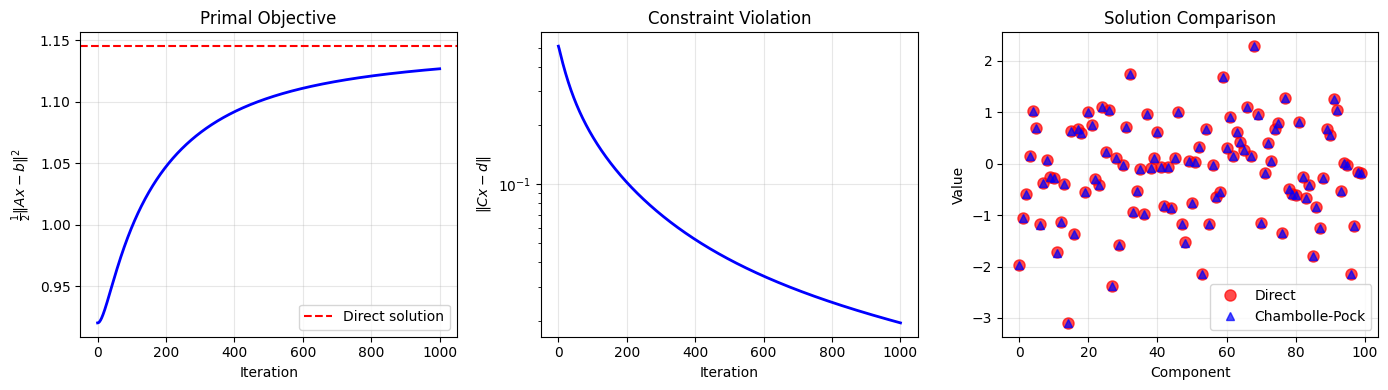

Direct solution objective: 1.145242
CP solution objective: 1.126850
Solution difference: 0.005625
Constraint violation: 0.019639


In [4]:
import numpy as np
import matplotlib.pyplot as plt

def chambolle_pock(prox_g, prox_h_conj, K, x0, y0, tau, sigma, theta=1.0, max_iter=1000):
    """
    Chambolle-Pock (PDHG) algorithm.
    Solves: min_x max_y { g(x) + <Kx, y> - h*(y) }
    Parameters:
        prox_g: proximal operator of tau*g
        prox_h_conj: proximal operator of sigma*h*
        K: linear operator (matrix or function)
        x0, y0: initial points
        tau, sigma: step sizes (must satisfy tau*sigma*||K||^2 < 1)
        theta: extrapolation parameter (typically 1)
    """
    x = x0.copy()
    y = y0.copy()
    x_bar = x.copy()

    # Handle K as matrix or operator
    if callable(K):
        Kop = K
        Ktop = lambda v: K(v, adjoint=True)
    else:
        Kop = lambda v: K @ v
        Ktop = lambda v: K.T @ v

    history = {'x': [x.copy()], 'y': [y.copy()]}

    for k in range(max_iter):
        # Dual update
        y_new = prox_h_conj(y + sigma * Kop(x_bar), sigma)

        # Primal update
        x_new = prox_g(x - tau * Ktop(y_new), tau)

        # Extrapolation
        x_bar = x_new + theta * (x_new - x)

        x, y = x_new, y_new
        history['x'].append(x.copy())
        history['y'].append(y.copy())

    return x, y, history

def demo_constrained_least_squares():
    """Solve constrained least squares with Chambolle-Pock."""
    np.random.seed(42)

    n = 100 # Variables
    m = 300 # Measurements
    p = 50 # Constraints

    # Problem: min ||Ax - b||^2 s.t. Cx = d
    A = np.random.randn(m, n)
    x_true = np.random.randn(n)
    b = A @ x_true + 0.1 * np.random.randn(m)

    C = np.random.randn(p, n)
    d = C @ x_true # Constraints satisfied by true solution

    # Proximal operators
    # prox_{tau * g}(v) where g(x) = 0.5*||Ax - b||^2
    AtA = A.T @ A
    Atb = A.T @ b

    def prox_g(v, tau):
        # Solve (A'A + (1/tau)I)x = A'b + (1/tau)v
        return np.linalg.solve(AtA + (1/tau) * np.eye(n), Atb + (1/tau) * v)

    # prox_{sigma * h*}(u) where h*(y) = d'y
    def prox_h_conj(u, sigma):
        return u - sigma * d

    # Step sizes: need tau * sigma * ||C||^2 < 1
    norm_C = np.linalg.norm(C, 2)
    tau = 0.3 / norm_C
    sigma = 0.3 / norm_C

    # Initial points
    x0 = np.zeros(n)
    x0 = np.linalg.lstsq(A, b, rcond=None)[0]  # optional warm start
    y0 = np.zeros(p)

    # Run Chambolle-Pock
    x_cp, y_cp, history = chambolle_pock(prox_g, prox_h_conj, C, x0, y0, tau, sigma, theta=1.0, max_iter=1000)

    # Compute metrics
    x_hist = np.array(history['x'])
    primal_obj = [0.5 * np.sum((A @ x - b)**2) for x in x_hist]
    constraint_viol = [np.linalg.norm(C @ x - d) for x in x_hist]

    # Compare with direct solution
    # KKT: [A'A C'] [x] [A'b]
    # [C 0 ] [nu] = [d ]
    KKT = np.block([[AtA, C.T], [C, np.zeros((p, p))]])
    rhs = np.concatenate([Atb, d])
    sol = np.linalg.solve(KKT, rhs)
    x_direct = sol[:n]

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    axes[0].plot(primal_obj, 'b-', linewidth=2)
    axes[0].axhline(0.5 * np.sum((A @ x_direct - b)**2), color='r', linestyle='--', label='Direct solution')
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('$\\frac{1}{2}\\|Ax - b\\|^2$')
    axes[0].set_title('Primal Objective')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].semilogy(constraint_viol, 'b-', linewidth=2)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('$\\|Cx - d\\|$')
    axes[1].set_title('Constraint Violation')
    axes[1].grid(True, alpha=0.3)

    axes[2].plot(x_direct, 'ro', markersize=8, label='Direct', alpha=0.7)
    axes[2].plot(x_cp, 'b^', markersize=6, label='Chambolle-Pock', alpha=0.7)
    axes[2].set_xlabel('Component')
    axes[2].set_ylabel('Value')
    axes[2].set_title('Solution Comparison')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('chambolle_pock_cls.pdf', bbox_inches='tight')
    plt.show()

    print(f"Direct solution objective: {0.5 * np.sum((A @ x_direct - b)**2):.6f}")
    print(f"CP solution objective: {0.5 * np.sum((A @ x_cp - b)**2):.6f}")
    print(f"Solution difference: {np.linalg.norm(x_cp - x_direct):.6f}")
    print(f"Constraint violation: {np.linalg.norm(C @ x_cp - d):.6f}")

demo_constrained_least_squares()